# Seismic Hazard Assessment for Antananarivo, Madagascar

This notebook demonstrates a workflow for probabilistic seismic hazard analysis (PSHA) at the city of Antananarivo, Madagascar. The main steps include:

- **Data Acquisition:** Downloading and processing earthquake catalog data for the region using ObsPy and USGS FDSN web services.
- **Geospatial Analysis:** Loading Madagascar's administrative boundaries and visualizing earthquake epicenters and city location using GeoPandas and Matplotlib.
- **Catalog Processing:** Filtering the earthquake catalog for completeness, extracting relevant event parameters (magnitude, location, depth, time), and preparing data for statistical analysis.
- **Gutenberg–Richter Law Fitting:** Estimating the frequency-magnitude distribution parameters (`a` and `b`) to model the annual rate of earthquakes above a given magnitude.
- **Distance Modeling:** Computing the distribution of earthquake distances to the city using the haversine formula and empirical binning.
- **Ground Motion Prediction:** Defining a Ground Motion Prediction Equation (GMPE) to estimate peak ground acceleration (PGA) at the city for different earthquake scenarios.
- **Hazard Curve Calculation:** Numerically integrating over magnitude and distance bins to compute the annual exceedance rate of ground motions (hazard curve).
- **Return Period Analysis:** Interpolating the hazard curve to estimate the PGA corresponding to a 475-year return period (10% probability of exceedance in 50 years).

Throughout the notebook, code cells are used for data processing, modeling, and visualization, while markdown cells provide documentation and explanations for each step. This workflow can be adapted for other regions and cities by modifying the input parameters and data sources.

# Dependency Management and Environment Setup

The following code cell ensures that all required Python packages for seismic hazard analysis are installed and available in the notebook environment. It checks for each package, installs any missing ones using `pip`, and imports them for use in subsequent cells. This step helps maintain reproducibility and prevents runtime errors due to missing dependencies.

In [ ]:
# 1) Install dependencies if missing
import sys, subprocess, importlib

def ensure(pkg, import_name=None):
    name = import_name or pkg
    try:
        importlib.import_module(name)
        print(f"[ok] {pkg} already installed")
    except Exception:
        print(f"[info] Installing {pkg} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
        importlib.import_module(name)
        print(f"[ok] {pkg} installed")


pkgs = ["os", "re", "requests", "zipfile", "geopandas",
        "matplotlib", "shapely", "cartopy", "obspy", 
        "folium", "osmnx", "numpy", "pandas"]

for pkg in pkgs:
    ensure(pkg)

# Import required libraries

In the next cell, we will import the required packages and define the parameters and constants needed for the exercise. We will also define functions that will be used later in the calculations.

In [1]:
#%% Imports and constants
import numpy as np
import matplotlib.pyplot as plt
from math import radians, sin, cos, asin, sqrt, log10, log, exp
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import geopandas as gpd
import requests, zipfile, io
from obspy.geodetics import gps2dist_azimuth
import pandas as pd
import os
import numpy as np
import pandas as pd
from math import radians, sin, cos, sqrt, atan2
from scipy.stats import norm

# Constants
R_EARTH_KM = 6371.0  # Earth radius in kilometers

# Functions for PGA and MMI calculations
def pga_joyner_boore_1981(M, E):
    """
    Joyner & Boore (1981) attenuation equation.
    PGA = 10^(0.249*M - log10(D) - 0.00255*D - 1.02)
    D = sqrt(E^2 + 7.3^2)
    
    Parameters
    ----------
    M : float
        Magnitude
    E : float
        Epicentral distance (km)
    
    Returns
    -------
    PGA : float
        Peak ground acceleration (in g)
    """
    D = np.sqrt(E**2 + 7.3**2)
    log10_pga = 0.249*M - np.log10(D) - 0.00255*D - 1.02
    PGA = 10**log10_pga
    return PGA

def mmi_from_pga(PGA):
    """
    Convert PGA (in g) to MMI using Trifunac & Brady (1975).
    MMI = (1/0.3) * (log10(PGA*980) - 0.014)
    
    Parameters
    ----------
    PGA : float
        Peak ground acceleration (in g)
    
    Returns
    -------
    MMI : float
        Modified Mercalli Intensity
    """
    return (np.log10(PGA*980) - 0.014) / 0.3

# Function to calculate haversine distance between two lat/lon points
def haversine(lat1, lon1, lat2, lon2):
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    # Haversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = R_EARTH_KM * c
    return km

# Setting Parameters

In the next section, we define the parameters required to fetch the earthquake catalog for the area surrounding the center of Antananarivo city. We also specify additional parameters needed for subsequent analyses.

In [2]:
#%% Parameters (scenario definition, city location, bounding box)
# Scenario earthquake definition
SCENARIO_MAG = 7.0
SCENARIO_DEPTH_KM = 10.0
# Scenario epicenter (latitude, longitude). Here we use the city location for a worst-case scenario.
SCENARIO_LAT = -18.9
SCENARIO_LON = 47.5

# City of interest
CITY_NAME = "Antananarivo"
CITY_LAT = -18.9
CITY_LON = 47.5

# Earthquake catalog search parameters
MIN_LAT = -26.0
MAX_LAT = -11.0
MIN_LON = 42.0
MAX_LON = 51.0
START_DATE = UTCDateTime(1900, 1, 1)
END_DATE = UTCDateTime.now()
MIN_MAG = 3.0

# Earthquake Catalog Acquisition and Processing

In this section, we fetch the earthquake catalog for Madagascar using the ObsPy FDSN client and USGS web services. The catalog is filtered to remove events with missing depth or magnitude information. For each event, we extract key parameters such as latitude, longitude, depth, magnitude, and origin time. We also compute the epicentral and hypocentral distances to Antananarivo using the haversine formula. The processed event data is stored in a GeoPandas GeoDataFrame for further analysis and visualization.

In [3]:
#%% Fetch earthquake catalog using ObsPy
client = Client("USGS")
catalog = client.get_events(starttime=START_DATE, endtime=END_DATE,
                            minlatitude=MIN_LAT, maxlatitude=MAX_LAT,
                            minlongitude=MIN_LON, maxlongitude=MAX_LON,
                            minmagnitude=MIN_MAG)
print(f"Fetched {catalog.count()} earthquake events from the catalog")

# Remove events with missing depth or magnitude
catalog = [event for event in catalog if event.origins and event.magnitudes and
           event.origins[0].depth is not None and event.magnitudes[0].mag is not None]
print(f"Number of events with depth and magnitude information: {len(catalog)}")

#%% Extract event data (latitude, longitude, depth, magnitude, distance, original_time)
# into geopandas dataframe
event_data = []
for event in catalog:
    origin = event.origins[0]
    magnitude = event.magnitudes[0].mag if event.magnitudes else None
    if origin and magnitude is not None:
        event_data.append({
            "Latitude": origin.latitude,
            "Longitude": origin.longitude,
            "Depth_km": origin.depth / 1000.0,  # convert to km
            "Magnitude": magnitude,
            "Distance": haversine(CITY_LAT, CITY_LON, origin.latitude, origin.longitude),
            "Hypo_dist": sqrt(haversine(CITY_LAT, CITY_LON, origin.latitude,
                                        origin.longitude)**2 + (origin.depth / 1000.0)**2),
            "original_time": event.origins[0].time.datetime or event.preferred_origin().time.datetime
        })

events_gdf = gpd.GeoDataFrame(event_data, geometry=gpd.points_from_xy(
    [d["Longitude"] for d in event_data],
    [d["Latitude"] for d in event_data]
))
events_gdf['Year'] = pd.DatetimeIndex([d["original_time"] for d in event_data]).year
events_gdf['Month'] = pd.DatetimeIndex([d["original_time"] for d in event_data]).month
events_gdf['Day'] = pd.DatetimeIndex([d["original_time"] for d in event_data]).day
events_gdf['Date'] = pd.to_datetime(events_gdf[['Year', 'Month', 'Day']])
events_gdf = events_gdf.drop(columns=['Month', 'Day'])
events_gdf.reset_index(drop=True, inplace=True)
print(f"Prepared GeoDataFrame with {len(events_gdf)} events")
quakes = events_gdf.copy()

print(events_gdf.head())

Fetched 297 earthquake events from the catalog
Number of events with depth and magnitude information: 297
Prepared GeoDataFrame with 297 events
   Latitude  Longitude  Depth_km  Magnitude    Distance   Hypo_dist  \
0  -19.0881    43.7141     10.00        4.6  398.593131  398.718552   
1  -16.8068    44.1831     10.00        4.6  421.185234  421.303929   
2  -12.3766    47.2801     10.00        4.3  725.750554  725.819445   
3  -12.5780    46.2637     10.29        4.3  715.303024  715.377034   
4  -25.7980    47.3106     10.00        5.3  767.269438  767.334602   

            original_time                  geometry  Year       Date  
0 2025-07-23 03:59:28.348  POINT (43.7141 -19.0881)  2025 2025-07-23  
1 2025-03-09 19:38:41.968  POINT (44.1831 -16.8068)  2025 2025-03-09  
2 2025-01-20 13:51:13.077  POINT (47.2801 -12.3766)  2025 2025-01-20  
3 2024-10-15 16:24:31.879   POINT (46.2637 -12.578)  2024 2024-10-15  
4 2024-09-18 00:25:13.745   POINT (47.3106 -25.798)  2024 2024-09-18  


# Madagascar Boundary and Earthquake Epicenter Visualization

This cell downloads and loads the administrative boundary shapefile for Madagascar, extracts the relevant provinces, and visualizes them using GeoPandas and Matplotlib. The city of Antananarivo is marked with a red star, and earthquake epicenters from the processed catalog are plotted as blue markers. This map provides spatial context for the seismic hazard analysis, showing the distribution of historical earthquakes relative to the city and administrative regions.

Downloaded: ne_admin1_10m/ne_10m_admin_1_states_provinces.zip
Extracted to: ne_admin1_10m
Loaded Madagascar boundary with 22 provinces


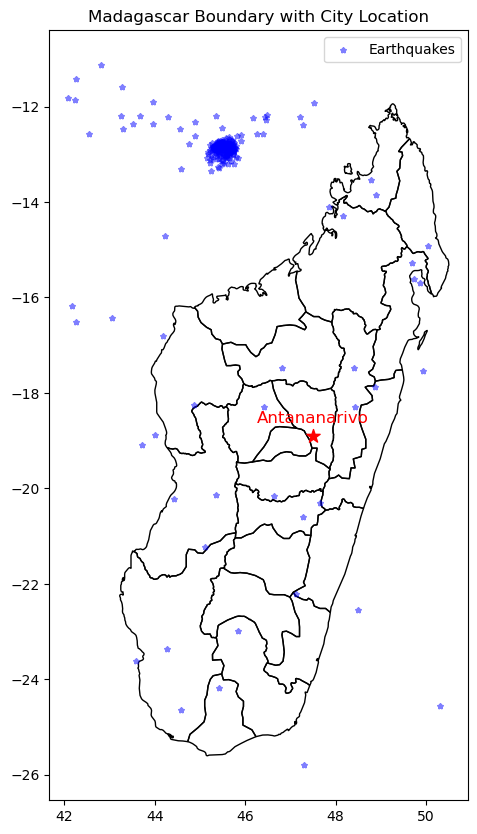

In [4]:
#%% Download and load Madagascar boundary and admin provinces shapefile
import os
import requests
from zipfile import ZipFile

URL = "https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces.zip"
OUT_DIR = "ne_admin1_10m"
ZIP_NAME = os.path.basename(URL)
ZIP_PATH = os.path.join(OUT_DIR, ZIP_NAME)

os.makedirs(OUT_DIR, exist_ok=True)

# Check if already downloaded
if os.path.exists(ZIP_PATH):
    print(f"Shapefile zip already downloaded: {ZIP_PATH}")
else:
    # Download with streaming to avoid loading whole file in memory
    with requests.get(URL, stream=True, timeout=60) as r:
        r.raise_for_status()
        with open(ZIP_PATH, "wb") as f:
            for chunk in r.iter_content(chunk_size=1024 * 64):
                if chunk:
                    f.write(chunk)

# Extract all contents
with ZipFile(ZIP_PATH) as zf:
    zf.extractall(OUT_DIR)

print(f"Downloaded: {ZIP_PATH}")
print(f"Extracted to: {OUT_DIR}")

#%% Load the shapefile using geopandas
shapefile_path = os.path.join(OUT_DIR, "ne_10m_admin_1_states_provinces.shp")
madagascar_boundary = gpd.read_file(shapefile_path)
madagascar_boundary = madagascar_boundary[madagascar_boundary['admin'] == 'Madagascar']
print(f"Loaded Madagascar boundary with {len(madagascar_boundary)} provinces")


# Plot and add the earthquake events to verify
madagascar_boundary.plot(figsize=(10, 10), facecolor='none', edgecolor='black')
plt.scatter(CITY_LON, CITY_LAT, marker='*', color='red', s=100)
plt.scatter(events_gdf['Longitude'], events_gdf['Latitude'], marker=(5, 2), color='blue', 
            s=10, alpha=0.5, label='Earthquakes')
plt.text(CITY_LON, CITY_LAT+0.2, CITY_NAME, fontsize=12, ha='center', va='bottom', color='red')
plt.title("Madagascar Boundary with City Location")
plt.legend()
plt.show()

# Earthquake Catalog Filtering and Magnitude-Frequency Analysis

This cell creates a simplified DataFrame (`quakes`) containing the key parameters for each earthquake: magnitude, year, latitude, and longitude. It then visualizes the frequency distribution of earthquake magnitudes in the catalog using a histogram. This plot helps assess the completeness of the catalog and provides insight into the observed magnitude-frequency relationship, which is essential for seismic hazard modeling.

   Magnitude  Year  Latitude  Longitude
0        4.6  2025  -19.0881    43.7141
1        4.6  2025  -16.8068    44.1831
2        4.3  2025  -12.3766    47.2801
3        4.3  2024  -12.5780    46.2637
4        5.3  2024  -25.7980    47.3106


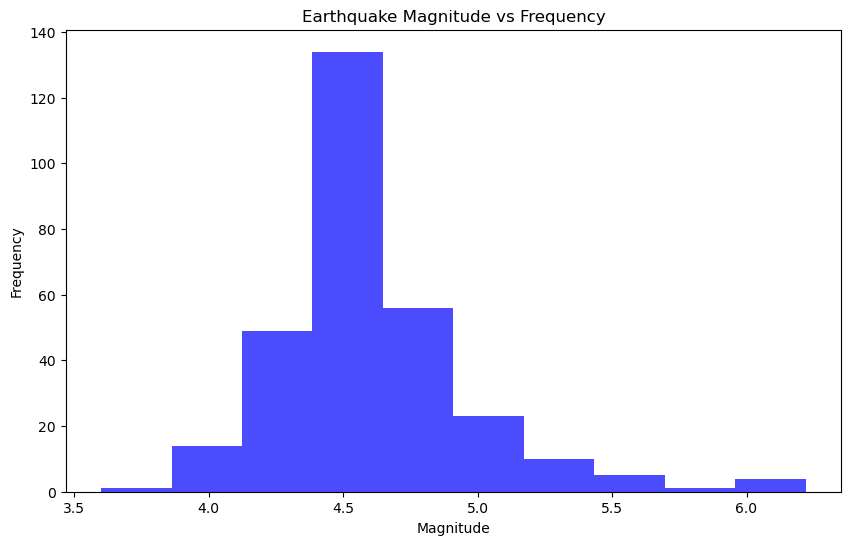

In [5]:
#%% Make a DataFrame `quakes` containing columns for 
# 'Magnitude', 'Year', 'Latitude', and 'Longitude' of each earthquake.
quakes = events_gdf[['Magnitude', 'Year', 'Latitude', 'Longitude']]
print(quakes.head())

#%% Plot the catalog events to check the completeness of the catalog
# Plot magnitude vs frequency
plt.figure(figsize=(10, 6))
plt.hist(quakes['Magnitude'].values, bins=10, color='blue', alpha=0.7)
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.title("Earthquake Magnitude vs Frequency")
plt.show()

# Gutenberg–Richter Law Fitting and Seismicity Rate Estimation

This cell fits the Gutenberg–Richter recurrence law to the earthquake catalog for Madagascar. The catalog is filtered for completeness above a minimum magnitude threshold (`M_min`). For each magnitude, the cumulative number of events per year is calculated, and a linear regression is performed on the log-transformed rates to estimate the Gutenberg–Richter parameters (`a` and `b`). The resulting model describes the expected annual frequency of earthquakes above a given magnitude, which is a key input for probabilistic seismic hazard analysis. The observed data and fitted relation are visualized to assess the fit quality and catalog completeness.

Fitted Gutenberg–Richter parameters: a = 5.10, b = 1.11


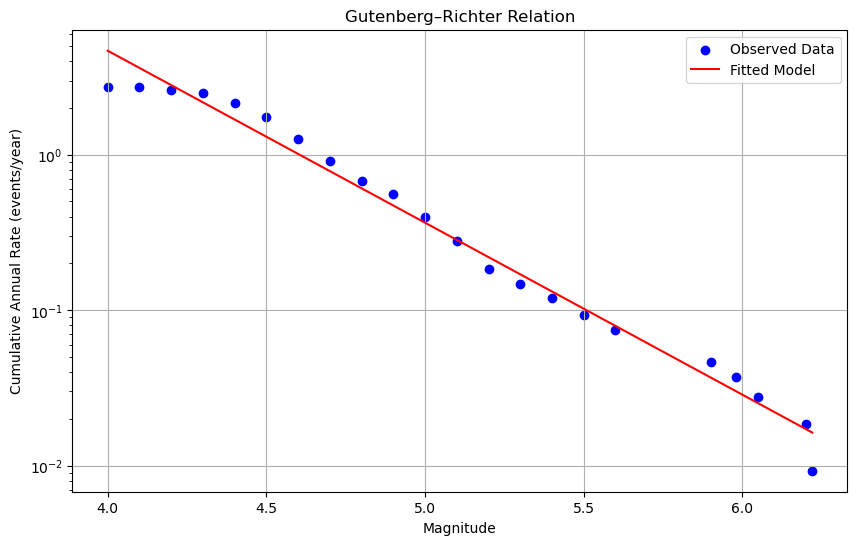

In [6]:
#%% Gutenberg–Richter fitting
# Fit the Gutenberg–Richter recurrence law (frequency–magnitude distribution) to the earthquake catalog.
# Steps:
# 1. Filter the catalog for completeness (e.g., use a minimum magnitude M_min).
# 2. Compute the cumulative number of events N(M >= m) for each magnitude m in the catalog.
# 3. Fit a linear relation log10(N) = a - b * m using least squares to estimate a and b.
# 4. Calculate the total annual occurrence rate of earthquakes above M_min.

# Set a completeness threshold for magnitude (adjust as needed based on data completeness).
M_min = 4.0
catalog = quakes[quakes['Magnitude'] >= M_min].copy()

# Calculate the timespan of the catalog in years for rate normalization.
years = catalog['Year'].max() - catalog['Year'].min() + 1

# Sort magnitudes and compute cumulative counts for N(M >= m).
mags = np.sort(catalog['Magnitude'].values)
unique_mags = np.unique(mags)

# Calculate cumulative number of events for each unique magnitude threshold.
cum_counts = np.array([np.sum(mags >= m) for m in unique_mags])

# Convert counts to annual rates:
annual_cum_rates = cum_counts / years

# Perform a linear fit to log10 of cumulative rates vs magnitude.
logN = np.log10(annual_cum_rates)
slope, intercept = np.polyfit(unique_mags, logN, 1)

# The fitted line is log10(N) ≈ intercept + slope * M.
# For Gutenberg-Richter form log10(N) = a - b*M, we have:
b_value = -slope
a_value = intercept  # intercept corresponds to log10 of annual N at M = 0 (extrapolated).
print(f"Fitted Gutenberg–Richter parameters: a = {a_value:.2f}, b = {b_value:.2f}")

# Plot the fitted Gutenberg–Richter relation
plt.figure(figsize=(10, 6))
plt.scatter(unique_mags, annual_cum_rates, color='blue', label='Observed Data')
plt.plot(unique_mags, 10**(intercept + slope * unique_mags), color='red', label='Fitted Model')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Magnitude')
plt.ylabel('Cumulative Annual Rate (events/year)')
plt.title('Gutenberg–Richter Relation')
plt.legend()
plt.grid()
plt.show()

# Magnitude and Distance Binning for Hazard Calculation

This cell prepares magnitude and distance bins required for the numerical integration of the seismic hazard curve. Magnitude bins are defined from the completeness threshold (`M_min`) to the maximum observed magnitude, with a specified bin width (`dM`). Distance bins and their empirical probabilities are taken from the previously computed distribution. The annual occurrence rate for each magnitude bin is calculated using the fitted Gutenberg–Richter law. A bar chart visualizes the annual rates per magnitude bin, providing insight into the frequency of different earthquake sizes in the region. These binned rates and probabilities are essential inputs for the subsequent hazard integration step.

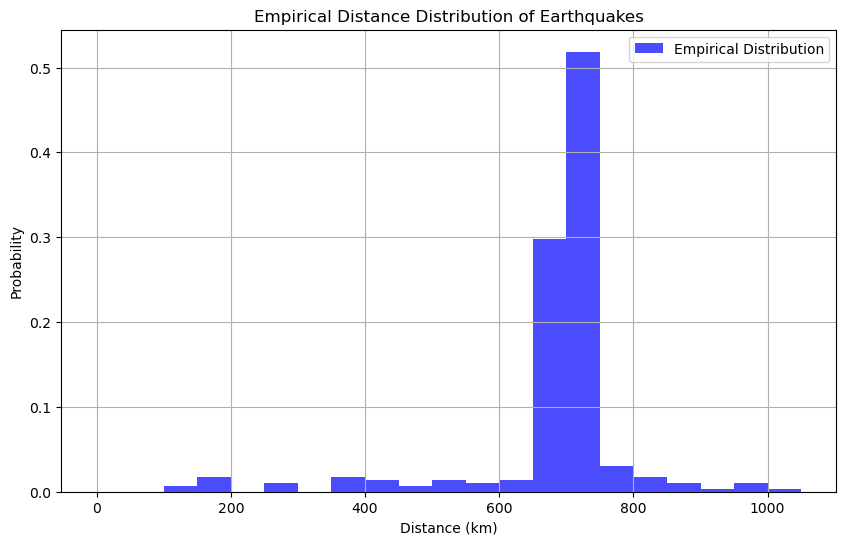

In [7]:
#%% Distance modeling to the city
# Compute the distance from each earthquake epicenter to the city (Antananarivo).
# We will use the haversine formula for great-circle distance between two lat/lon points.
# Compute distances and add as a new column in the catalog DataFrame.
city_lat = CITY_LAT
city_lon = CITY_LON
catalog['Distance_km'] = catalog.apply(lambda row: haversine(city_lat, city_lon, 
                                                            row['Latitude'], row['Longitude']), axis=1)

# Derive an empirical distance distribution from the catalog (for use in hazard integration).
# For simplicity, bin the distances and compute the proportion of events in each bin.
max_dist = catalog['Distance_km'].max()
# Define distance bins (adjust bin size for region as needed, e.g., 50 km bins here):
bin_width = 50.0  # km
dist_bins = np.arange(0, max_dist + bin_width, bin_width)
hist_counts, bin_edges = np.histogram(catalog['Distance_km'], bins=dist_bins)
distance_prob = hist_counts / hist_counts.sum()  # probability of an event falling in each distance bin
# Define representative distance for each bin (bin midpoints):
dist_bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Plot the empirical distance distribution as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(dist_bin_centers, distance_prob, width=bin_width, color='blue', 
        alpha=0.7, label='Empirical Distribution')
plt.xlabel('Distance (km)')
plt.ylabel('Probability')
plt.title('Empirical Distance Distribution of Earthquakes')
plt.legend()
plt.grid()
plt.show()

# Hazard Curve Calculation and Annual Exceedance Rate

This cell performs the core probabilistic seismic hazard analysis (PSHA) integration. Using the previously defined magnitude and distance bins, Gutenberg–Richter rates, and ground motion prediction equation (GMPE), it computes the annual exceedance rate for a range of peak ground acceleration (PGA) levels at Antananarivo. The calculation applies the total probability theorem, summing over all magnitude and distance combinations weighted by their occurrence rates and empirical probabilities. The resulting hazard curve shows the expected frequency of exceeding different PGA levels, providing a quantitative measure of seismic risk for the city.


In [8]:
#%% GMPE definition and probability model
# Define the Ground Motion Prediction Equation (GMPE) and the probability model for ground motion.
# We use an example GMPE (e.g., from Fukushima & Tanaka 1990, as cited in RADIUS methodology for rock site conditions).
# Formula (for PGA in rock): PGA = 10^(0.249*M - log10(D) - 0.00255*D - 1.02), where 
# D = sqrt(distance^2 + 7.3^2) (distance in km, includes a near-source saturation term 7.3 km).
# This yields PGA in units of g (approximate). We assume rock site (no site amplification).
def gmpe_pga(magnitude, distance_km):
    # Effective distance with near-source term
    D = np.sqrt(distance_km**2 + 7.3**2)
    # Compute log10(PGA) based on magnitude and distance
    log10_pga = 0.249 * magnitude - np.log10(D) - 0.00255 * D - 1.02
    return 10**(log10_pga)

# Define the standard deviation of log10(PGA) for the GMPE (aleatory uncertainty).
sigma_log10 = 0.22  # e.g., sigma(log10 PGA) ≈ 0.22 for rock (from Joyner & Boore 1981) [oai_citation:0‡file-8jqdxfnb1b5dxt3fpqbkme](file://file-8jQDxfnb1b5Dxt3FpqbKme#:~:text=ln%20PGA%20%3D%20%E2%88%921,S) [oai_citation:1‡file-8jqdxfnb1b5dxt3fpqbkme](file://file-8jQDxfnb1b5Dxt3FpqbKme#:~:text=PGA%3D10%5E%280.249%2AM)

# Probability that ground motion (PGA) exceeds a threshold x given magnitude m and distance d.
def prob_exceedance(magnitude, distance_km, pga_threshold):
    median_pga = gmpe_pga(magnitude, distance_km)  # median PGA (g) from GMPE
    # Calculate standard normal variate for log10(PGA) distribution
    z = (np.log10(pga_threshold) - np.log10(median_pga)) / sigma_log10
    # Return the exceedance probability (1 - CDF)
    return 1 - norm.cdf(z)


# Numerical Integration of the Seismic Hazard Curve

This cell implements the total probability theorem to numerically integrate the seismic hazard curve for Antananarivo. Using the previously defined magnitude and distance bins, annual occurrence rates, empirical distance probabilities, and the ground motion prediction equation (GMPE), it calculates the annual exceedance rate for a range of peak ground acceleration (PGA) levels. The resulting hazard curve quantifies the likelihood of experiencing different levels of ground shaking at the city, providing a key metric for seismic risk assessment and engineering design. The curve is visualized on a log-log scale to highlight both frequent and rare events.

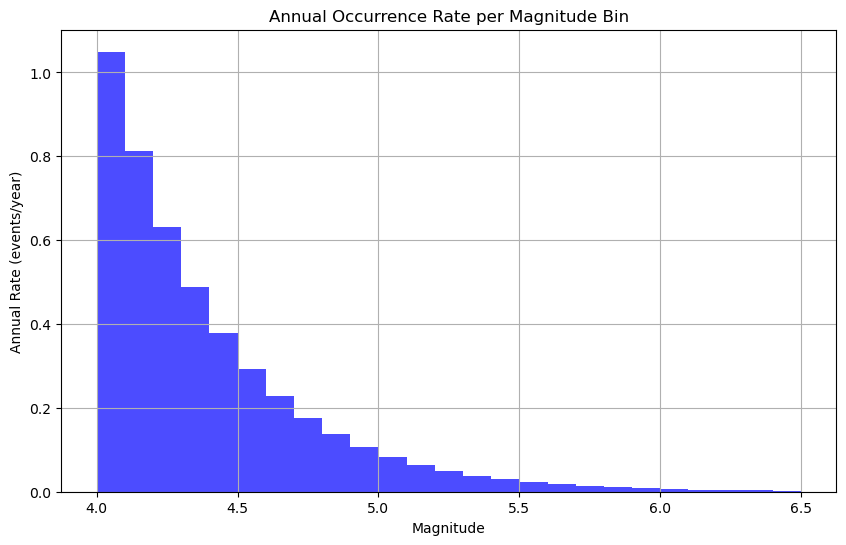

In [9]:
#%% Magnitude and distance binning
# Prepare magnitude and distance bins for the numerical integration in hazard calculation.
# Define magnitude bins from M_min to a maximum magnitude (M_max). 
M_max = max(M_min, catalog['Magnitude'].max())
# Extend M_max slightly (e.g., to next 0.5) to account for the possibility of larger events.
M_max = np.ceil(M_max * 2) / 2.0
dM = 0.1  # magnitude bin width
mag_bins = np.arange(M_min, M_max + dM, dM)
mag_bin_centers = 0.5 * (mag_bins[:-1] + mag_bins[1:])

# Use the distance bins and probabilities from the empirical distribution:
distance_bins = dist_bin_centers  # representative distances for each bin
distance_probs = distance_prob    # probability of an event in each distance bin

# Compute the annual occurrence rate for each magnitude bin using the Gutenberg–Richter law.
# N(M >= m) = 10^(a - b*m). Rate in bin [m_i, m_{i+1}) = N(>= m_i) - N(>= m_{i+1}).
N_gt = 10**(a_value - b_value * mag_bins)  # cumulative annual rates at bin edges
annual_rate_bins = N_gt[:-1] - N_gt[1:]    # annual rate in each mag bin

# Plot the annual rates per magnitude bin
plt.figure(figsize=(10, 6))
plt.bar(mag_bin_centers, annual_rate_bins, width=dM, color='blue', alpha=0.7)
plt.xlabel('Magnitude')
plt.ylabel('Annual Rate (events/year)')
plt.title('Annual Occurrence Rate per Magnitude Bin')
plt.grid()
plt.show()  

# Seismic Hazard Curve Integration and Interpretation

This cell performs the numerical integration of the seismic hazard curve for Antananarivo using the total probability theorem. For each ground motion level (PGA), it sums the contributions from all magnitude and distance bins, weighted by their annual occurrence rates and empirical probabilities. The resulting hazard curve quantifies the expected frequency of exceeding different PGA levels at the city. This analysis provides a key metric for seismic risk assessment, supporting engineering design and disaster planning. The hazard curve is visualized to illustrate the relationship between ground shaking intensity and exceedance probability.

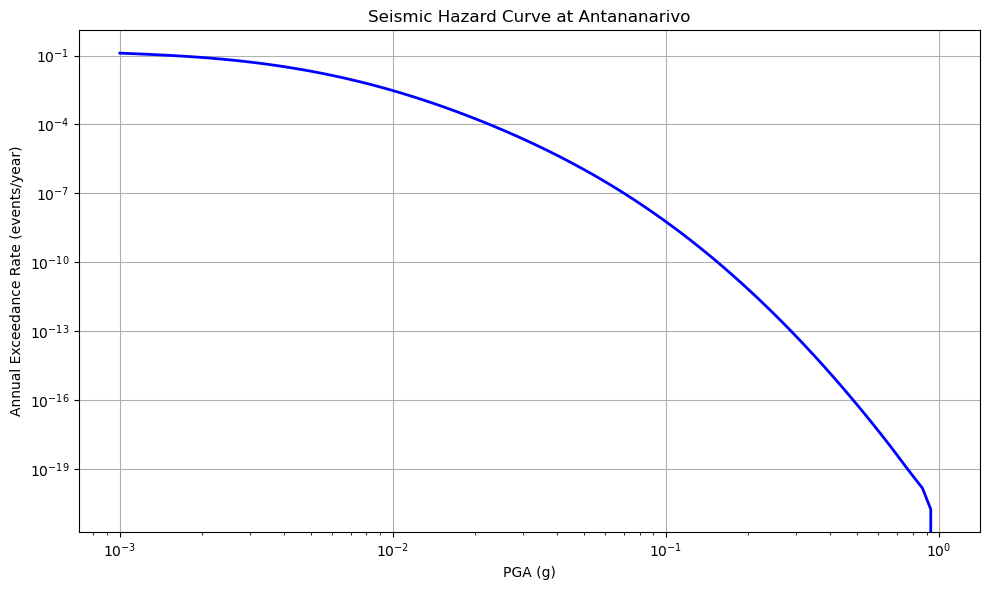

In [12]:
#%% Hazard integration loop (compute annual exceedance rate)
# Compute the annual exceedance rate for a range of PGA levels using the total probability theorem.
# λ_exceed(X) = ∑_m ∑_r [ λ_m * P(r) * P(PGA > X | m, r) ],
# where λ_m is rate of events in mag bin m, P(r) is probability of an event at distance r, and the last term is conditional exceedance probability.

# Define an array of PGA levels (in g) for the hazard curve.
pga_min = 1e-3  # 0.001g
pga_max = 1.0   # 1.0g (adjust if necessary)
pga_levels = np.logspace(np.log10(pga_min), np.log10(pga_max), 100)  # log-spaced for resolution

exceedance_rates = []  # will store computed annual exceedance frequencies for each PGA level
for x in pga_levels:
    total_rate = 0.0
    # Sum contributions from each magnitude and distance bin
    for i, m in enumerate(mag_bin_centers):
        lam_m = annual_rate_bins[i]            # annual rate of events in this magnitude bin
        for j, r in enumerate(distance_bins):
            p_r = distance_probs[j]            # probability of an event occurring at distance ~r
            p_exc = prob_exceedance(m, r, x)   # probability that PGA > x given an event of mag m at distance r
            total_rate += lam_m * p_r * p_exc
    exceedance_rates.append(total_rate)
exceedance_rates = np.array(exceedance_rates)

# Plot the hazard curve (annual exceedance rate vs PGA)
plt.figure(figsize=(10, 6))
plt.plot(pga_levels, exceedance_rates, color='blue', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('PGA (g)')
plt.ylabel('Annual Exceedance Rate (events/year)')
plt.title('Seismic Hazard Curve at Antananarivo')
plt.grid()
plt.tight_layout()
plt.show()

# Return Period Ground Motion Estimation

This cell calculates the peak ground acceleration (PGA) at Antananarivo corresponding to a 475-year return period, which represents a 10% probability of exceedance in 50 years—a standard metric in seismic hazard analysis for engineering design. The target annual exceedance rate is computed, and the hazard curve is interpolated to find the PGA value matching this rate. The result is visualized on the hazard curve plot, with the 475-year return period PGA highlighted for reference. This value is crucial for seismic risk mitigation and building code applications.

PGA for 10% in 50 years (~475-year return period) is approximately 0.011 g


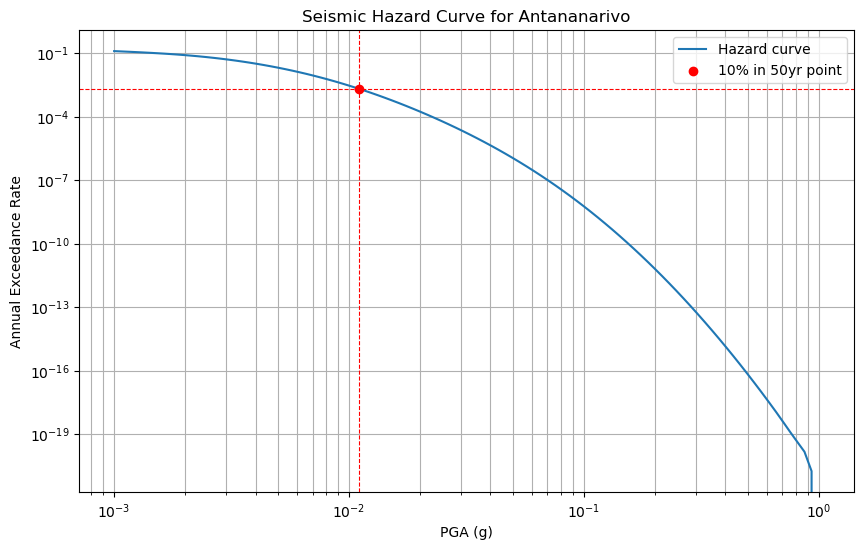

In [13]:
#%% Compute PGA for 10% in 50 years (475-year return period)
# 10% probability of exceedance in 50 years corresponds to an annual exceedance rate:
target_exceedance_rate = -np.log(1 - 0.10) / 50.0  # ~0.002105 per year
# Interpolate the hazard curve to find the PGA value corresponding to this target rate.
pga_475 = None
if (exceedance_rates[-1] <= target_exceedance_rate) and (exceedance_rates[0] >= target_exceedance_rate):
    # Interpolate in log-log space for better accuracy (hazard curve is roughly log-linear in log-log scale).
    # Taking logs:
    log_target = np.log10(target_exceedance_rate)
    # Avoid taking log10 of zero which produces -inf and runtime warnings.
    # Clip zero (or non-positive) exceedance rates to a tiny positive value
    # based on the smallest positive rate computed (or a safe floor) so
    # interpolation in log-log space remains well-defined.
    if np.any(exceedance_rates > 0):
        min_pos = exceedance_rates[exceedance_rates > 0].min()
        eps = min_pos * 1e-6
    else:
        # if all rates are zero (degenerate case), use a very small floor
        eps = 1e-20
    clipped_rates = np.clip(exceedance_rates, eps, None)
    with np.errstate(divide='ignore'):
        log_rates = np.log10(clipped_rates)
    log_pga = np.log10(pga_levels)
    # Perform linear interpolation to find log10(PGA) at log_target.
    pga_475_log = np.interp(log_target, log_rates[::-1], log_pga[::-1])
    pga_475 = 10**pga_475_log
else:
    # If target rate is outside the range of computed hazard curve:
    if exceedance_rates[0] < target_exceedance_rate:
        print("Warning: target exceedance rate is higher than the curve maximum.")
    if exceedance_rates[-1] > target_exceedance_rate:
        print("Warning: target exceedance rate is lower than the curve minimum.")
# Report the 475-year return period PGA value
if pga_475 is not None:
    print(f"PGA for 10% in 50 years (~475-year return period) is approximately {pga_475:.3f} g")
else:
    print("PGA for 475-year return period could not be determined from the computed range.")

# Plot hazard curve
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.loglog(pga_levels, exceedance_rates, label='Hazard curve')
# Mark the 10% in 50yr point if available
if pga_475 is not None:
    plt.scatter([pga_475], [target_exceedance_rate], color='red', zorder=5, label='10% in 50yr point')
    plt.axhline(y=target_exceedance_rate, color='red', linestyle='--', linewidth=0.8)
    plt.axvline(x=pga_475, color='red', linestyle='--', linewidth=0.8)
plt.title('Seismic Hazard Curve for Antananarivo')
plt.xlabel('PGA (g)')
plt.ylabel('Annual Exceedance Rate')
plt.legend()
plt.grid(True, which='both')
plt.show()

# Extra tasks:
* Use the scenario earthquake definition in the third cell to calculate the deterministic seismic hazard curve at the center of Antananarivo city.